<a href="https://colab.research.google.com/github/yahyahabib65/AI-623/blob/main/AI_623_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4.1

Import Libraries

In [14]:
!pip install git+https://github.com/openai/CLIP.git

import os
import clip
import torch
from torchvision.datasets import STL10
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ctebunol
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ctebunol
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [15]:
# 1. Model Setup and Resource Allocation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device.upper()}")
model, preprocess = clip.load('ViT-B/32', device)

# 2. Load STL-10 Test Set (using split='test')
# Task 4.1(a): Download STL-10

stl10_test = STL10(root=os.path.expanduser("~/.cache"), split='test', download=True, transform=preprocess)
dataloader = DataLoader(stl10_test, batch_size=32, shuffle=False, num_workers=2)

# 3. Define the 3 Prompting Strategies (Task 4.1.c)
class_names = stl10_test.classes

def get_text_features(prompt_template):
    # Create prompts for all classes using the template
    prompts = [prompt_template.format(c) for c in class_names]
    text_inputs = torch.cat([clip.tokenize(p) for p in prompts]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)


    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

strategies = {
    "Plain labels": get_text_features("{}"),
    "Standard Prompt": get_text_features("a photo of a {}"),
    "Descriptive Prompt": get_text_features("a high resolution photo of a {}")
}

# 4. Evaluate Whole Test Set (Task 4.1.d)
results = {name: 0 for name in strategies}

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Encode images once
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Compare against each prompt strategy
        for name, text_embeds in strategies.items():
            # Calculate similarity
            similarity = (100.0 * image_features @ text_embeds.T)

            # Get predictions (argmax gives index highest probs)
            predictions = similarity.argmax(dim=-1)

            #how many matched the true labels
            correct = (predictions == labels).sum().item()
            results[name] += correct

# 5. Print Final Results
print("\n--- Zero-Shot Accuracy Results on STL-10 ---")
for name, correct_count in results.items():
    accuracy = 100 * correct_count / len(stl10_test)
    print(f"{name:>25s}: {accuracy:.2f}%")

Using CPU


100%|██████████| 250/250 [15:13<00:00,  3.65s/it]


--- Zero-Shot Accuracy Results on STL-10 ---
             Plain labels: 96.25%
          Standard Prompt: 97.36%
       Descriptive Prompt: 97.06%


## 4.2

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


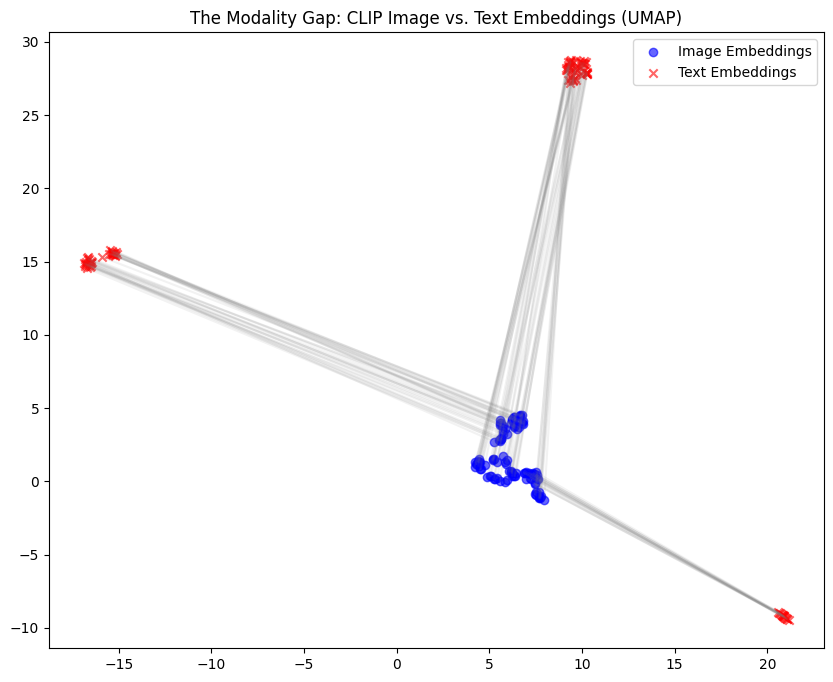

In [24]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import umap  # pip install umap-learn

# 1. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# 2. Get Data (Subset of STL-10)
# We use the test split but only take the first 100 images for clarity
stl10 = STL10(root="~/.cache", split='test', download=True, transform=preprocess)
subset_indices = range(100)
subset = torch.utils.data.Subset(stl10, subset_indices)
loader = DataLoader(subset, batch_size=100, shuffle=False)

# 3. Extract Embeddings (Part a)
images, labels = next(iter(loader))
images = images.to(device)
class_names = [stl10.classes[i] for i in labels]

with torch.no_grad():
    # Image Embeddings
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize!

    # Text Embeddings (One per image, corresponding to its ground truth label)
    # We use the prompt "a photo of a {label}" to represent the text modality
    text_prompts = [f"a photo of a {name}" for name in class_names]
    text_inputs = torch.cat([clip.tokenize(p) for p in text_prompts]).to(device)

    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)   # Normalize!

# Move to CPU for plotting
img_emb = image_features.cpu().numpy()
txt_emb = text_features.cpu().numpy()

# 4. Dimensionality Reduction (Part b)
# We combine them to project into the SAME 2D space
combined_emb = np.concatenate([img_emb, txt_emb], axis=0)

# Option A: UMAP (Faster, often better structure preservation)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
projections = reducer.fit_transform(combined_emb)

# Option B: t-SNE (Standard alternative)
# reducer = TSNE(n_components=2, perplexity=10, metric='cosine', random_state=42)
# projections = reducer.fit_transform(combined_emb)

# Split back into image and text coordinates
n = len(images)
img_proj = projections[:n]
txt_proj = projections[n:]

# 5. Visualization (Part c)
plt.figure(figsize=(10, 8))
plt.scatter(img_proj[:, 0], img_proj[:, 1], c='blue', alpha=0.6, label='Image Embeddings')
plt.scatter(txt_proj[:, 0], txt_proj[:, 1], c='red', alpha=0.6, marker='x', label='Text Embeddings')

# Draw lines connecting specific Image-Text pairs to see alignment
for i in range(n):
    plt.plot([img_proj[i, 0], txt_proj[i, 0]], [img_proj[i, 1], txt_proj[i, 1]],
             color='gray', alpha=0.1)

plt.title("The Modality Gap: CLIP Image vs. Text Embeddings (UMAP)")
plt.legend()
plt.show()